In [146]:
from dotenv import load_dotenv
import os
from datetime import datetime as dt
from datetime import timedelta
import requests
import time
import json
import matplotlib.pyplot as plt

load_dotenv()


True

In [147]:
OUNCE_TO_GRAM= 31.1035
GRAM_PER_BAHT = 15.244

class QuoteRequest:
    def __init__(self, start_date: dt, end_date: dt, currency_from, currency_to):
        self.start_date = start_date
        self.end_date = end_date
        self.currency_from = currency_from
        self.currency_to = currency_to

class HistoricalQuote:
    def __init__(
        self,
        base_currency: str,
        close: float,
        open: float,
        high: float,
        low: float,
        quote_currency: str,
        ratio: int
    ):
        self.base_currency = base_currency
        self.close = close / ratio
        self.open = open / ratio
        self.high = high / ratio
        self.low = low / ratio
        self.quote_currency = quote_currency

    def __str__(self):
        return f"Historical Quote:\n\t\t\tBase Currency: {self.base_currency}\n\t\t\tQuote Currency: {self.quote_currency}\n\t\t\tOpen: {self.open}\n\t\t\tClose: {self.close}\n\t\t\tHigh: {self.high}\n\t\t\tLow: {self.low}"


class HistoricalResponse:
    def __init__(
        self, date: str, endpoint: str, request_time: str, quotes: list[HistoricalQuote]
    ):
        self.date = date
        self.endpoint = endpoint
        self.request_time = request_time
        self.quotes = quotes

    def __str__(self):
        quotes = ""
        for quote in self.quotes:
            quotes = quotes + str(quote)
        return f"Historical Response:\n\tDate: {self.date}\n\tRequest Time: {self.request_time}\n\tEndpoint: {self.endpoint}\n\tQuotes:\n\t\t{quotes}"

class QuoteData:
    def __init__(self, data: dict):
        self.date = dt.strptime(data['date'], '%Y-%m-%d')
        self.value = round(data['value'], 2)
        self.key = data['key']

    def __str__(self):
        return f'Quote:\n\tDate: {self.date}\n\tValue: {self.currency} {self.value}'

In [148]:
class MarketData:
    base_url = "https://marketdata.tradermade.com/api/v1/"
    historical_api = "historical?"
    live_api = "live?"
    date_parameter = "&date="
    currency_parameter = "&currency="
    api_key_parameter = "&api_key="

    def __init__(self, api_key, ratio):
        self.ratio = ratio
        shared_parameters = self.api_key_parameter + api_key
        self.historical_url = self.base_url + self.historical_api + shared_parameters
        self.live_url = self.base_url + self.live_api + shared_parameters

    def live_data(self, currency_from, currency_to):
        url = self.live_url + self.currency_parameter + currency_from + currency_to
        print(url)

    def historical_data(self, currency_from, currency_to, date: dt):
        url = (
            self.historical_url
            + self.date_parameter
            + date.strftime("%Y-%m-%d")
            + self.currency_parameter
            + currency_from
            + currency_to
        )
        result: HistoricalResponse
        try:
            result = self.fetch_data(url)
        except:
            previous_day = date - timedelta(days = 1)
            result = self.historical_data(currency_from, currency_to, previous_day)
        return result

    def fetch_data(self, url):
        response = requests.get(url)
        json_response = response.json()
        quotes: list[HistoricalQuote] = []
        quotes = self.map_quotes(json_response.get("quotes"))
        result = self.map_historical_data(json_response, quotes)
        return result

    def map_quotes(self, quotes_response):
        quotes: list[HistoricalQuote] = []
        for quote_response in quotes_response:
            quote: HistoricalQuote = HistoricalQuote(
                quote_response.get("base_currency"),
                quote_response.get("close"),
                quote_response.get("open"),
                quote_response.get("high"),
                quote_response.get("low"),
                quote_response.get("quote_currency"),
                self.ratio
            )
            quotes.append(quote)

        return quotes

    def map_historical_data(self, json_response, quotes: list[HistoricalQuote]):
        historical_response: HistoricalResponse = HistoricalResponse(
            json_response.get("date"),
            json_response.get("endpoint"),
            json_response.get("request_time"),
            quotes,
        )
        return historical_response

    def __del__(self):
        self.live_url = ""
        self.historical_url = ""

In [149]:
class HistoricalCrawler:

    def __init__(self, market_data: MarketData):
        self.market_data = market_data

    def daterange(self, start_date: dt, end_date: dt):
        for n in range(int((end_date - start_date).days / 7)):
            yield start_date + timedelta(n)*7
        
    def start_crawling(self, request: QuoteRequest):
        historical_responses: list[HistoricalResponse] = []
        for date in self.daterange(request.start_date, request.end_date):
            result = self.market_data.historical_data(request.currency_from, request.currency_to, date)
            historical_responses.append(result)
            time.sleep(0.5)

        return historical_responses


In [150]:
class HistoricalDownloader:
    def __init__(self, ratio):
        api_key = os.getenv("MARKETDATA_API_KEY", "")
        market_data = MarketData(api_key, ratio)
        self.historical_crawler = HistoricalCrawler(market_data)

    def start_downloading(self, request: QuoteRequest, filename: str):
        results = self.historical_crawler.start_crawling(request)
        lines: list[str] = []
        lines.append("{")
        lines.append('"data": [')
        for result in results:
            lines.append(
                f'{{"date":"{result.date}","value":{result.quotes[0].close},"key":"{result.quotes[0].quote_currency}"}},'
            )
        line = lines[len(lines) - 1][:-1]
        lines[len(lines) - 1] = line
        lines.append("]}")
        file = open(filename, "w")
        file.writelines(lines)
        file.close()

In [151]:
def download(currency_from: str, currency_to: str, start: int, ratio: int):
    historical_downloader = HistoricalDownloader(ratio)
    start_date = dt(start, 1, 1)
    end = start + 1
    end_date = dt(end, 1, 1)
    if end_date > dt.today():
        end_date = dt.today()
    request = QuoteRequest(start_date, end_date, currency_from, currency_to)
    print(
        f'Starting to crawl from {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")} for {currency_from}{currency_to}'
    )
    historical_downloader.start_downloading(request, f"historical_{currency_from.lower()}_{currency_to.lower()}_{start}.json")
    print("Complete.")

def get_quote_data(filename):
    file = open(filename, "r")
    json_data = json.load(file)
    quotes: list[QuoteData] = []
    for data in json_data['data']:
        quote = QuoteData(data)
        quotes.append(quote)
    file.close()
    return quotes

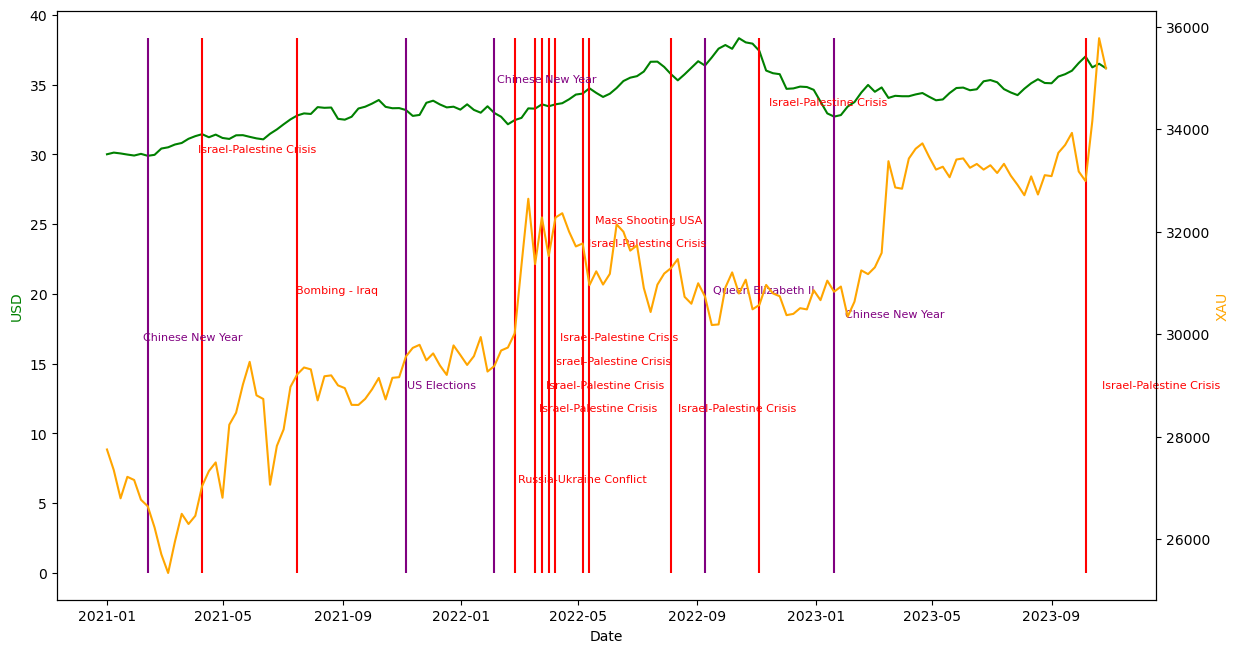

In [152]:
x1 = []
y1 = []
x2 = []
y2 = []
x3 = []
y3 = []
z3 = []
x4 = []
y4 = []
z4 = []
shift_y = 5

for n in range(2021, 2024):
    quotes: QuoteData = get_quote_data(f"historical_usd_thb_{n}.json")
    for quote in quotes:
        x1.append(quote.date)
        x2.append(quote.date)
        x3.append(quote.date)
        x4.append(quote.date)
        y1.append(quote.value)
    quotes: QuoteData = get_quote_data(f"historical_xau_thb_{n}.json")
    for quote in quotes:
        y2.append(quote.value)

for n in range(2021, 2024):
    quotes: QuoteData = get_quote_data(f"attack_{n}.json")
    for quote in quotes:
        y3.append(quote.value * (max(y1) + shift_y))
        z3.append(quote.key)
    quotes: QuoteData = get_quote_data(f"events_{n}.json")
    for quote in quotes:
        y4.append(quote.value * (max(y1) + shift_y))
        z4.append(quote.key)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Date")
ax1.set_ylabel("USD", color="green")
plt.plot(x1, y1, color="green")
plt.vlines(x=x3, ymin=0, ymax=y3, colors="red")
plt.vlines(x=x4, ymin=0, ymax=y4, colors="purple")

indx = 0
step = 1 / (len(x1) + 10)
base_y = 0.2
factor_y = .04
factor_x = .04
modulus = 20

for text in z3:
    if len(text) > 0:
        y = base_y + (indx % modulus) * factor_y
        plt.text( indx * step + factor_x, y, text, fontsize=8, transform=plt.gca().transAxes, color = 'red')
    indx = indx + 1

indx = 0
for text in z4:
    if len(text) > 0:
        y = base_y + (indx % modulus) * factor_y
        plt.text( indx * step + factor_x, y, text, fontsize=8, transform=plt.gca().transAxes, color = 'purple')
    indx = indx + 1

ax2 = ax1.twinx()
ax2.set_ylabel("XAU", color="orange")
plt.plot(x2, y2, color="orange", label="XAU")

fig.tight_layout()
fig.set_size_inches(15, 7)
fig.set_dpi(100)
plt.show()